# Deep Learning Training Monitoring

In this section, we will study how to monitor training, which will be crucial when selecting model architecture and hyperparameters. 

For the sake of the tutorial, we use a [n-gram](https://en.wikipedia.org/wiki/N-gram) language model, which computes the probability of the target word given $n-1$ previous words. Note that you are not required to have knowledge in this model. Code for training the model is written based on [this link](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#sphx-glr-beginner-nlp-word-embeddings-tutorial-py).

In [ ]:
import numpy as np

train = np.load("wiki.train.npy", allow_pickle=True)
val = np.load("wiki.valid.npy", allow_pickle=True)
vocab = np.load("vocab.npy", allow_pickle=True)

In [ ]:
# example text in train set
" ".join([vocab[i] for i in train[0]])

'= Valkyria Chronicles III = <eol> Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . <eol> The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more <unk> for series newcomers . 

In [ ]:
# get trigrams of train val data
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_trigrams = []
for sentence in train[:10]:
    for i in range(len(sentence) - 2):
        train_trigrams.append(
            (torch.tensor([sentence[i], sentence[i + 1]], dtype=torch.long, device=device), 
             torch.tensor([sentence[i + 2]], dtype=torch.long, device=device))
        )

# print the first train data to check if they look good
print(train_trigrams[:3])


val_trigrams = []
for sentence in val[:5]: 
    for i in range(len(sentence) - 2):
        val_trigrams.append(
            (torch.tensor([sentence[i], sentence[i + 1]], dtype=torch.long, device=device), 
             torch.tensor([sentence[i + 2]], dtype=torch.long, device=device))
        )

# print the first validation data to check if they look good
print(val_trigrams[:3])

[(tensor([ 1420, 13859], device='cuda:0'), tensor([3714], device='cuda:0')), (tensor([13859,  3714], device='cuda:0'), tensor([7036], device='cuda:0')), (tensor([3714, 7036], device='cuda:0'), tensor([1420], device='cuda:0'))]
[(tensor([1420, 6836], device='cuda:0'), tensor([21764], device='cuda:0')), (tensor([ 6836, 21764], device='cuda:0'), tensor([1420], device='cuda:0')), (tensor([21764,  1420], device='cuda:0'), tensor([1417], device='cuda:0'))]


In [ ]:
len(train_trigrams), len(val_trigrams)

(16522, 18225)

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm

CONTEXT_SIZE = 2
EMBEDDING_DIM = 100

class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


def train_epoch(loader, model, optimizer):
    train_cum_loss = acc = 0.
    tstart = time.time()
    model.train()
    for i, (context, target) in enumerate(tqdm(loader)):
        # This is a regular training step 
        optimizer.zero_grad()
        log_probs = model(context)
        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()

        # Check if loss is decreasing every 1000 batches
        if i and i % 1000 == 0:
            print(f"Epoch {epoch} Batch {i} Loss {loss}")

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        train_cum_loss += loss.item()

        acc += 1 if target == log_probs.argmax(1) else 0

    elapsed = round(time.time() - tstart, 2)
    train_cum_loss /= (i + 1) # take mean since batch_size = 1
    acc /= (i + 1)

    return train_cum_loss, acc, elapsed

def validate(loader, model, optimizer):
    val_cum_loss = 0
    tstart = time.time()

    acc = cum_loss = 0.
    model.eval()
    with torch.no_grad():
        for i, (context, target) in enumerate(tqdm(loader)):
            log_probs = model(context)
            loss = loss_function(log_probs, target)
            acc += 1 if target == log_probs.argmax(1) else 0
            cum_loss += loss.item()

    acc /= (i + 1)
    cum_loss /= (i + 1)

    return acc, cum_loss

When monitoring training of a deep learning models, there are several metrics you could follow to ensure that the models are being trained well and to choose a combination of hyperparameters and/or early stopping rule to choose the final model. To introduce general metrics,
* Train and/or Validation Loss: Loss is the most fundamental metric you could follow. You want to check whether it is decreasing, how fast it is decreasing, and how far it decreases eventually. It is often used for scheduling learning rate, which will be discussed later in the course.
* Train and/or Validation Time: Training time often tells you about performance of your code. If training is taking too much time, you may want to check yourimplementation of dataloader, model, and etc.

There are task-specific metrics as well. The most widely used ones are accuracy, f-1, precision, and recall. They can be used on a wide range of machine learning tasks, but other metrics like hit rate (recommender systems), levenshtein distance (language modeling), and BLUE scores (text summarization) are also used.

In this example, we will track train loss, train accuracy, validation loss, and validation accuracy.

In [ ]:
from collections import defaultdict

## HYPERPARAMETERS
n_epochs = 20
lr = 1e-3

loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

metrics1 = defaultdict(list)
for epoch in tqdm(range(n_epochs)):
    # train one epoch
    train_loss, train_acc, elapsed = train_epoch(train_trigrams, model, optimizer)

    # check validation
    val_acc, val_loss = validate(val_trigrams, model, optimizer)

    print(f"[END OF EPOCH] Epoch {epoch} Avg. Train Loss {train_loss} Train Time {elapsed}")
    print(f"[END OF EPOCH] Epoch {epoch} Validation Loss {val_loss} Validation acc {val_acc}")

    metrics1["train_loss"].append(train_loss)
    metrics1["train_acc"].append(train_acc)
    metrics1["val_loss"].append(val_loss)
    metrics1["val_acc"].append(val_acc)
# save your model, metrics, optimizer, scheduler, and etc...

Epoch 0 Batch 1000 Loss 10.369540214538574
Epoch 0 Batch 2000 Loss 10.322310447692871
Epoch 0 Batch 3000 Loss 10.798702239990234
Epoch 0 Batch 4000 Loss 10.136964797973633
Epoch 0 Batch 5000 Loss 10.306489944458008
Epoch 0 Batch 6000 Loss 9.021636962890625
Epoch 0 Batch 7000 Loss 9.123159408569336
Epoch 0 Batch 8000 Loss 11.035484313964844
Epoch 0 Batch 9000 Loss 5.969326019287109
Epoch 0 Batch 10000 Loss 10.553484916687012
Epoch 0 Batch 11000 Loss 8.689751625061035
Epoch 0 Batch 12000 Loss 9.98508071899414
Epoch 0 Batch 13000 Loss 4.906050205230713
Epoch 0 Batch 14000 Loss 10.712742805480957
Epoch 0 Batch 15000 Loss 11.851605415344238
Epoch 0 Batch 16000 Loss 1.6928633451461792




[END OF EPOCH] Epoch 0 Avg. Train Loss 9.219848976912798 Train Time 27.7
[END OF EPOCH] Epoch 0 Validation Loss 8.187419011061412 Validation acc 0.09075445816186557


Epoch 1 Batch 1000 Loss 10.763967514038086
Epoch 1 Batch 2000 Loss 10.144410133361816
Epoch 1 Batch 3000 Loss 11.087089538574219
Epoch 1 Batch 4000 Loss 2.9645214080810547
Epoch 1 Batch 5000 Loss 10.638484954833984
Epoch 1 Batch 6000 Loss 4.526625156402588
Epoch 1 Batch 7000 Loss 4.833478927612305
Epoch 1 Batch 8000 Loss 10.820018768310547
Epoch 1 Batch 9000 Loss 3.283827781677246
Epoch 1 Batch 10000 Loss 10.907824516296387
Epoch 1 Batch 11000 Loss 4.623669624328613
Epoch 1 Batch 12000 Loss 9.768407821655273
Epoch 1 Batch 13000 Loss 3.110640048980713
Epoch 1 Batch 14000 Loss 11.311356544494629
Epoch 1 Batch 15000 Loss 12.031185150146484
Epoch 1 Batch 16000 Loss 0.668426513671875




[END OF EPOCH] Epoch 1 Avg. Train Loss 7.763265875215833 Train Time 28.4
[END OF EPOCH] Epoch 1 Validation Loss 7.659711049357723 Validation acc 0.10216735253772291


Epoch 2 Batch 1000 Loss 10.122665405273438
Epoch 2 Batch 2000 Loss 9.813493728637695
Epoch 2 Batch 3000 Loss 11.38424015045166
Epoch 2 Batch 4000 Loss 2.0994365215301514
Epoch 2 Batch 5000 Loss 10.064024925231934
Epoch 2 Batch 6000 Loss 3.9396166801452637
Epoch 2 Batch 7000 Loss 4.417424201965332
Epoch 2 Batch 8000 Loss 10.587204933166504
Epoch 2 Batch 9000 Loss 3.0797505378723145
Epoch 2 Batch 10000 Loss 11.121554374694824
Epoch 2 Batch 11000 Loss 3.039484739303589
Epoch 2 Batch 12000 Loss 9.56185531616211
Epoch 2 Batch 13000 Loss 2.9913976192474365
Epoch 2 Batch 14000 Loss 11.254096031188965
Epoch 2 Batch 15000 Loss 12.19248104095459
Epoch 2 Batch 16000 Loss 0.4910973310470581




[END OF EPOCH] Epoch 2 Avg. Train Loss 7.155896407326927 Train Time 27.77
[END OF EPOCH] Epoch 2 Validation Loss 7.4667946796673155 Validation acc 0.10573388203017833


Epoch 3 Batch 1000 Loss 9.529083251953125
Epoch 3 Batch 2000 Loss 9.006141662597656
Epoch 3 Batch 3000 Loss 11.386005401611328
Epoch 3 Batch 4000 Loss 1.8221971988677979
Epoch 3 Batch 5000 Loss 9.360466003417969
Epoch 3 Batch 6000 Loss 3.6713297367095947
Epoch 3 Batch 7000 Loss 4.631050109863281
Epoch 3 Batch 8000 Loss 10.417606353759766
Epoch 3 Batch 9000 Loss 2.985849380493164
Epoch 3 Batch 10000 Loss 11.158556938171387
Epoch 3 Batch 11000 Loss 2.3373708724975586
Epoch 3 Batch 12000 Loss 9.331634521484375
Epoch 3 Batch 13000 Loss 2.9329674243927
Epoch 3 Batch 14000 Loss 11.157299041748047
Epoch 3 Batch 15000 Loss 12.33374309539795
Epoch 3 Batch 16000 Loss 0.4209285378456116




[END OF EPOCH] Epoch 3 Avg. Train Loss 6.7368855611253755 Train Time 28.4
[END OF EPOCH] Epoch 3 Validation Loss 7.365403585116314 Validation acc 0.10765432098765432


Epoch 4 Batch 1000 Loss 8.697529792785645
Epoch 4 Batch 2000 Loss 8.055076599121094
Epoch 4 Batch 3000 Loss 11.364815711975098
Epoch 4 Batch 4000 Loss 1.5958548784255981
Epoch 4 Batch 5000 Loss 8.514131546020508
Epoch 4 Batch 6000 Loss 3.571812152862549
Epoch 4 Batch 7000 Loss 4.720170021057129
Epoch 4 Batch 8000 Loss 10.27247428894043
Epoch 4 Batch 9000 Loss 2.9152112007141113
Epoch 4 Batch 10000 Loss 11.095152854919434
Epoch 4 Batch 11000 Loss 2.003732681274414
Epoch 4 Batch 12000 Loss 9.0372314453125
Epoch 4 Batch 13000 Loss 2.8993637561798096
Epoch 4 Batch 14000 Loss 11.112509727478027
Epoch 4 Batch 15000 Loss 12.454645156860352
Epoch 4 Batch 16000 Loss 0.3687762916088104




[END OF EPOCH] Epoch 4 Avg. Train Loss 6.4080941291236675 Train Time 27.75
[END OF EPOCH] Epoch 4 Validation Loss 7.30220720209539 Validation acc 0.10666666666666667


Epoch 5 Batch 1000 Loss 7.672880172729492
Epoch 5 Batch 2000 Loss 7.363521575927734
Epoch 5 Batch 3000 Loss 11.33531379699707
Epoch 5 Batch 4000 Loss 1.479851484298706
Epoch 5 Batch 5000 Loss 7.5851545333862305
Epoch 5 Batch 6000 Loss 3.4846253395080566
Epoch 5 Batch 7000 Loss 4.777759075164795
Epoch 5 Batch 8000 Loss 10.060844421386719
Epoch 5 Batch 9000 Loss 2.87125825881958
Epoch 5 Batch 10000 Loss 10.98748779296875
Epoch 5 Batch 11000 Loss 1.8502150774002075
Epoch 5 Batch 12000 Loss 8.694387435913086
Epoch 5 Batch 13000 Loss 2.8631153106689453
Epoch 5 Batch 14000 Loss 10.989822387695312
Epoch 5 Batch 15000 Loss 12.523893356323242
Epoch 5 Batch 16000 Loss 0.3353857100009918




[END OF EPOCH] Epoch 5 Avg. Train Loss 6.135561589589493 Train Time 28.5
[END OF EPOCH] Epoch 5 Validation Loss 7.2685976273173 Validation acc 0.10551440329218106


Epoch 6 Batch 1000 Loss 6.564336776733398
Epoch 6 Batch 2000 Loss 7.0051116943359375
Epoch 6 Batch 3000 Loss 11.286079406738281
Epoch 6 Batch 4000 Loss 1.463221549987793
Epoch 6 Batch 5000 Loss 6.780618190765381
Epoch 6 Batch 6000 Loss 3.407893180847168
Epoch 6 Batch 7000 Loss 4.851378917694092
Epoch 6 Batch 8000 Loss 9.826698303222656
Epoch 6 Batch 9000 Loss 2.8435921669006348
Epoch 6 Batch 10000 Loss 10.836028099060059
Epoch 6 Batch 11000 Loss 1.7973822355270386
Epoch 6 Batch 12000 Loss 8.288174629211426
Epoch 6 Batch 13000 Loss 2.850196361541748
Epoch 6 Batch 14000 Loss 10.844874382019043
Epoch 6 Batch 15000 Loss 12.53249740600586
Epoch 6 Batch 16000 Loss 0.3070850074291229




[END OF EPOCH] Epoch 6 Avg. Train Loss 5.896322354048985 Train Time 28.37
[END OF EPOCH] Epoch 6 Validation Loss 7.260877811389123 Validation acc 0.10414266117969821


Epoch 7 Batch 1000 Loss 5.622255325317383
Epoch 7 Batch 2000 Loss 6.804891586303711
Epoch 7 Batch 3000 Loss 11.200299263000488
Epoch 7 Batch 4000 Loss 1.4675074815750122
Epoch 7 Batch 5000 Loss 6.257462024688721
Epoch 7 Batch 6000 Loss 3.3279309272766113
Epoch 7 Batch 7000 Loss 4.954580307006836
Epoch 7 Batch 8000 Loss 9.570197105407715
Epoch 7 Batch 9000 Loss 2.8125574588775635
Epoch 7 Batch 10000 Loss 10.626689910888672
Epoch 7 Batch 11000 Loss 1.797459363937378
Epoch 7 Batch 12000 Loss 7.847723007202148
Epoch 7 Batch 13000 Loss 2.8586220741271973
Epoch 7 Batch 14000 Loss 10.686203956604004
Epoch 7 Batch 15000 Loss 12.466630935668945
Epoch 7 Batch 16000 Loss 0.27375710010528564




[END OF EPOCH] Epoch 7 Avg. Train Loss 5.680796422987848 Train Time 27.63
[END OF EPOCH] Epoch 7 Validation Loss 7.272015435383317 Validation acc 0.10315500685871057


Epoch 8 Batch 1000 Loss 5.064548492431641
Epoch 8 Batch 2000 Loss 6.617310047149658
Epoch 8 Batch 3000 Loss 11.051024436950684
Epoch 8 Batch 4000 Loss 1.4938753843307495
Epoch 8 Batch 5000 Loss 5.939842700958252
Epoch 8 Batch 6000 Loss 3.263852596282959
Epoch 8 Batch 7000 Loss 5.05810546875
Epoch 8 Batch 8000 Loss 9.264431953430176
Epoch 8 Batch 9000 Loss 2.80111026763916
Epoch 8 Batch 10000 Loss 10.368707656860352
Epoch 8 Batch 11000 Loss 1.8247349262237549
Epoch 8 Batch 12000 Loss 7.396413803100586
Epoch 8 Batch 13000 Loss 2.8558433055877686
Epoch 8 Batch 14000 Loss 10.453997611999512
Epoch 8 Batch 15000 Loss 12.296050071716309
Epoch 8 Batch 16000 Loss 0.2400124967098236




[END OF EPOCH] Epoch 8 Avg. Train Loss 5.4812744860344 Train Time 28.68
[END OF EPOCH] Epoch 8 Validation Loss 7.296188071929992 Validation acc 0.10299039780521262


Epoch 9 Batch 1000 Loss 4.836267471313477
Epoch 9 Batch 2000 Loss 6.427724361419678
Epoch 9 Batch 3000 Loss 10.832596778869629
Epoch 9 Batch 4000 Loss 1.5390962362289429
Epoch 9 Batch 5000 Loss 5.697131156921387
Epoch 9 Batch 6000 Loss 3.2200114727020264
Epoch 9 Batch 7000 Loss 5.164718151092529
Epoch 9 Batch 8000 Loss 8.928295135498047
Epoch 9 Batch 9000 Loss 2.779711961746216
Epoch 9 Batch 10000 Loss 10.070974349975586
Epoch 9 Batch 11000 Loss 1.8513283729553223
Epoch 9 Batch 12000 Loss 6.977545738220215
Epoch 9 Batch 13000 Loss 2.8357930183410645
Epoch 9 Batch 14000 Loss 10.179079055786133
Epoch 9 Batch 15000 Loss 12.002725601196289
Epoch 9 Batch 16000 Loss 0.20756608247756958




[END OF EPOCH] Epoch 9 Avg. Train Loss 5.293132474994781 Train Time 27.77
[END OF EPOCH] Epoch 9 Validation Loss 7.330938316432782 Validation acc 0.10079561042524006


Epoch 10 Batch 1000 Loss 4.748913288116455
Epoch 10 Batch 2000 Loss 6.2269978523254395
Epoch 10 Batch 3000 Loss 10.563899993896484
Epoch 10 Batch 4000 Loss 1.5887868404388428
Epoch 10 Batch 5000 Loss 5.4589619636535645
Epoch 10 Batch 6000 Loss 3.1898632049560547
Epoch 10 Batch 7000 Loss 5.2726030349731445
Epoch 10 Batch 8000 Loss 8.580819129943848
Epoch 10 Batch 9000 Loss 2.7332701683044434
Epoch 10 Batch 10000 Loss 9.717389106750488
Epoch 10 Batch 11000 Loss 1.858224630355835
Epoch 10 Batch 12000 Loss 6.573443412780762
Epoch 10 Batch 13000 Loss 2.8039636611938477
Epoch 10 Batch 14000 Loss 9.861258506774902
Epoch 10 Batch 15000 Loss 11.609984397888184
Epoch 10 Batch 16000 Loss 0.1787412017583847




[END OF EPOCH] Epoch 10 Avg. Train Loss 5.113893927891637 Train Time 28.47
[END OF EPOCH] Epoch 10 Validation Loss 7.373281110033945 Validation acc 0.09838134430727023


Epoch 11 Batch 1000 Loss 4.703693389892578
Epoch 11 Batch 2000 Loss 6.0205912590026855
Epoch 11 Batch 3000 Loss 10.25548267364502
Epoch 11 Batch 4000 Loss 1.663736343383789
Epoch 11 Batch 5000 Loss 5.207433700561523
Epoch 11 Batch 6000 Loss 3.1851108074188232
Epoch 11 Batch 7000 Loss 5.372738361358643
Epoch 11 Batch 8000 Loss 8.202168464660645
Epoch 11 Batch 9000 Loss 2.6956446170806885
Epoch 11 Batch 10000 Loss 9.309438705444336
Epoch 11 Batch 11000 Loss 1.8637858629226685
Epoch 11 Batch 12000 Loss 6.210289001464844
Epoch 11 Batch 13000 Loss 2.767817258834839
Epoch 11 Batch 14000 Loss 9.51447582244873
Epoch 11 Batch 15000 Loss 11.130228042602539
Epoch 11 Batch 16000 Loss 0.1555424928665161




[END OF EPOCH] Epoch 11 Avg. Train Loss 4.941555802623659 Train Time 28.03
[END OF EPOCH] Epoch 11 Validation Loss 7.422608981548677 Validation acc 0.09574759945130315


Epoch 12 Batch 1000 Loss 4.665843486785889
Epoch 12 Batch 2000 Loss 5.804551601409912
Epoch 12 Batch 3000 Loss 9.903993606567383
Epoch 12 Batch 4000 Loss 1.691777229309082
Epoch 12 Batch 5000 Loss 4.9610443115234375
Epoch 12 Batch 6000 Loss 3.1679792404174805
Epoch 12 Batch 7000 Loss 5.475882530212402
Epoch 12 Batch 8000 Loss 7.800226211547852
Epoch 12 Batch 9000 Loss 2.6498546600341797
Epoch 12 Batch 10000 Loss 8.85904312133789
Epoch 12 Batch 11000 Loss 1.860450267791748
Epoch 12 Batch 12000 Loss 5.852010726928711
Epoch 12 Batch 13000 Loss 2.7098453044891357
Epoch 12 Batch 14000 Loss 9.11700439453125
Epoch 12 Batch 15000 Loss 10.582939147949219
Epoch 12 Batch 16000 Loss 0.13517023622989655




[END OF EPOCH] Epoch 12 Avg. Train Loss 4.774340591883424 Train Time 28.59
[END OF EPOCH] Epoch 12 Validation Loss 7.477626265587875 Validation acc 0.09454046639231825


Epoch 13 Batch 1000 Loss 4.639734745025635
Epoch 13 Batch 2000 Loss 5.607762813568115
Epoch 13 Batch 3000 Loss 9.511905670166016
Epoch 13 Batch 4000 Loss 1.742935299873352
Epoch 13 Batch 5000 Loss 4.685652732849121
Epoch 13 Batch 6000 Loss 3.1558213233947754
Epoch 13 Batch 7000 Loss 5.542727470397949
Epoch 13 Batch 8000 Loss 7.399441719055176
Epoch 13 Batch 9000 Loss 2.581721305847168
Epoch 13 Batch 10000 Loss 8.387113571166992
Epoch 13 Batch 11000 Loss 1.8389651775360107
Epoch 13 Batch 12000 Loss 5.4802141189575195
Epoch 13 Batch 13000 Loss 2.659385919570923
Epoch 13 Batch 14000 Loss 8.713274955749512
Epoch 13 Batch 15000 Loss 9.966287612915039
Epoch 13 Batch 16000 Loss 0.11931060999631882




[END OF EPOCH] Epoch 13 Avg. Train Loss 4.611367586316577 Train Time 27.93
[END OF EPOCH] Epoch 13 Validation Loss 7.539069556883333 Validation acc 0.09393689986282579


Epoch 14 Batch 1000 Loss 4.615865707397461
Epoch 14 Batch 2000 Loss 5.417951583862305
Epoch 14 Batch 3000 Loss 9.100272178649902
Epoch 14 Batch 4000 Loss 1.7677820920944214
Epoch 14 Batch 5000 Loss 4.421494960784912
Epoch 14 Batch 6000 Loss 3.1228551864624023
Epoch 14 Batch 7000 Loss 5.628547668457031
Epoch 14 Batch 8000 Loss 6.984858512878418
Epoch 14 Batch 9000 Loss 2.5023727416992188
Epoch 14 Batch 10000 Loss 7.871399402618408
Epoch 14 Batch 11000 Loss 1.7847576141357422
Epoch 14 Batch 12000 Loss 5.078857421875
Epoch 14 Batch 13000 Loss 2.610112190246582
Epoch 14 Batch 14000 Loss 8.28717041015625
Epoch 14 Batch 15000 Loss 9.303935050964355
Epoch 14 Batch 16000 Loss 0.10611891001462936




[END OF EPOCH] Epoch 14 Avg. Train Loss 4.451931254791602 Train Time 28.58
[END OF EPOCH] Epoch 14 Validation Loss 7.607003620684413 Validation acc 0.09135802469135802


Epoch 15 Batch 1000 Loss 4.579250335693359
Epoch 15 Batch 2000 Loss 5.265357971191406
Epoch 15 Batch 3000 Loss 8.66688346862793
Epoch 15 Batch 4000 Loss 1.785095453262329
Epoch 15 Batch 5000 Loss 4.157511234283447
Epoch 15 Batch 6000 Loss 3.087191581726074
Epoch 15 Batch 7000 Loss 5.701824188232422
Epoch 15 Batch 8000 Loss 6.599143028259277
Epoch 15 Batch 9000 Loss 2.4094643592834473
Epoch 15 Batch 10000 Loss 7.347243785858154
Epoch 15 Batch 11000 Loss 1.708855390548706
Epoch 15 Batch 12000 Loss 4.652988433837891
Epoch 15 Batch 13000 Loss 2.5492794513702393
Epoch 15 Batch 14000 Loss 7.887503147125244
Epoch 15 Batch 15000 Loss 8.588234901428223
Epoch 15 Batch 16000 Loss 0.09525872021913528




[END OF EPOCH] Epoch 15 Avg. Train Loss 4.296089637881167 Train Time 28.52
[END OF EPOCH] Epoch 15 Validation Loss 7.680292841399648 Validation acc 0.08982167352537723


Epoch 16 Batch 1000 Loss 4.561119079589844
Epoch 16 Batch 2000 Loss 5.150691032409668
Epoch 16 Batch 3000 Loss 8.190896034240723
Epoch 16 Batch 4000 Loss 1.7999480962753296
Epoch 16 Batch 5000 Loss 3.8987388610839844
Epoch 16 Batch 6000 Loss 3.0552754402160645
Epoch 16 Batch 7000 Loss 5.761797904968262
Epoch 16 Batch 8000 Loss 6.25619649887085
Epoch 16 Batch 9000 Loss 2.2757301330566406
Epoch 16 Batch 10000 Loss 6.816858768463135
Epoch 16 Batch 11000 Loss 1.616546392440796
Epoch 16 Batch 12000 Loss 4.208622932434082
Epoch 16 Batch 13000 Loss 2.465392827987671
Epoch 16 Batch 14000 Loss 7.493752479553223
Epoch 16 Batch 15000 Loss 7.863831520080566
Epoch 16 Batch 16000 Loss 0.08702047914266586




[END OF EPOCH] Epoch 16 Avg. Train Loss 4.143472083755577 Train Time 27.75
[END OF EPOCH] Epoch 16 Validation Loss 7.758838812205966 Validation acc 0.0893278463648834


Epoch 17 Batch 1000 Loss 4.551227569580078
Epoch 17 Batch 2000 Loss 5.07465124130249
Epoch 17 Batch 3000 Loss 7.700325965881348
Epoch 17 Batch 4000 Loss 1.8151730298995972
Epoch 17 Batch 5000 Loss 3.6591150760650635
Epoch 17 Batch 6000 Loss 3.048699378967285
Epoch 17 Batch 7000 Loss 5.812615871429443
Epoch 17 Batch 8000 Loss 5.928571701049805
Epoch 17 Batch 9000 Loss 2.1242055892944336
Epoch 17 Batch 10000 Loss 6.292914390563965
Epoch 17 Batch 11000 Loss 1.5382405519485474
Epoch 17 Batch 12000 Loss 3.7627484798431396
Epoch 17 Batch 13000 Loss 2.3868751525878906
Epoch 17 Batch 14000 Loss 7.148136615753174
Epoch 17 Batch 15000 Loss 7.145705223083496
Epoch 17 Batch 16000 Loss 0.07991717755794525




[END OF EPOCH] Epoch 17 Avg. Train Loss 3.9944443912925705 Train Time 28.61
[END OF EPOCH] Epoch 17 Validation Loss 7.843305488752689 Validation acc 0.08768175582990398


Epoch 18 Batch 1000 Loss 4.537562370300293
Epoch 18 Batch 2000 Loss 5.029938697814941
Epoch 18 Batch 3000 Loss 7.195578575134277
Epoch 18 Batch 4000 Loss 1.8048909902572632
Epoch 18 Batch 5000 Loss 3.416504383087158
Epoch 18 Batch 6000 Loss 3.010373830795288
Epoch 18 Batch 7000 Loss 5.9095377922058105
Epoch 18 Batch 8000 Loss 5.625646114349365
Epoch 18 Batch 9000 Loss 1.9651011228561401
Epoch 18 Batch 10000 Loss 5.795516490936279
Epoch 18 Batch 11000 Loss 1.4546972513198853
Epoch 18 Batch 12000 Loss 3.333432912826538
Epoch 18 Batch 13000 Loss 2.3192086219787598
Epoch 18 Batch 14000 Loss 6.863096714019775
Epoch 18 Batch 15000 Loss 6.470150947570801
Epoch 18 Batch 16000 Loss 0.0732780247926712




[END OF EPOCH] Epoch 18 Avg. Train Loss 3.8491266184033557 Train Time 27.92
[END OF EPOCH] Epoch 18 Validation Loss 7.933425484046708 Validation acc 0.08631001371742113


Epoch 19 Batch 1000 Loss 4.52291202545166
Epoch 19 Batch 2000 Loss 4.998751163482666
Epoch 19 Batch 3000 Loss 6.667574882507324
Epoch 19 Batch 4000 Loss 1.768650770187378
Epoch 19 Batch 5000 Loss 3.2001953125
Epoch 19 Batch 6000 Loss 2.985506057739258
Epoch 19 Batch 7000 Loss 5.962468147277832
Epoch 19 Batch 8000 Loss 5.34567928314209
Epoch 19 Batch 9000 Loss 1.817771315574646
Epoch 19 Batch 10000 Loss 5.329980850219727
Epoch 19 Batch 11000 Loss 1.3765689134597778
Epoch 19 Batch 12000 Loss 2.9204726219177246
Epoch 19 Batch 13000 Loss 2.2564237117767334
Epoch 19 Batch 14000 Loss 6.607853889465332
Epoch 19 Batch 15000 Loss 5.885515213012695
Epoch 19 Batch 16000 Loss 0.06915470957756042




[END OF EPOCH] Epoch 19 Avg. Train Loss 3.707636492562378 Train Time 28.74
[END OF EPOCH] Epoch 19 Validation Loss 8.028458546794777 Validation acc 0.08411522633744856



To demonstrate how one can use these training metrics in choosing the best model, we will train another model with a different hyperparameter. We will train a model with a lower learning rate at 1e-4 for the second model.

In [ ]:
# train a new model with lower learning rate
lr = 1e-4

model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

metrics2 = defaultdict(list)

for epoch in tqdm(range(n_epochs)):
    # train one epoch
    train_loss, train_acc, elapsed = train_epoch(train_trigrams, model, optimizer)

    # check validation
    val_acc, val_loss = validate(val_trigrams, model, optimizer)

    print(f"[END OF EPOCH] Epoch {epoch} Avg. Train Loss {train_loss} Train Time {elapsed}")
    print(f"[END OF EPOCH] Epoch {epoch} Validation Loss {val_loss} Validation acc {val_acc}")

    metrics2["train_loss"].append(train_loss)
    metrics2["train_acc"].append(train_acc)
    metrics2["val_loss"].append(val_loss)
    metrics2["val_acc"].append(val_acc)
# save your model, metrics, optimizer, scheduler, and etc...

Epoch 0 Batch 1000 Loss 10.328027725219727
Epoch 0 Batch 2000 Loss 10.567331314086914
Epoch 0 Batch 3000 Loss 10.478225708007812
Epoch 0 Batch 4000 Loss 10.599419593811035
Epoch 0 Batch 5000 Loss 10.348036766052246
Epoch 0 Batch 6000 Loss 10.152650833129883
Epoch 0 Batch 7000 Loss 9.950630187988281
Epoch 0 Batch 8000 Loss 10.460936546325684
Epoch 0 Batch 9000 Loss 10.159446716308594
Epoch 0 Batch 10000 Loss 10.445298194885254
Epoch 0 Batch 11000 Loss 9.925546646118164
Epoch 0 Batch 12000 Loss 10.683807373046875
Epoch 0 Batch 13000 Loss 9.801868438720703
Epoch 0 Batch 14000 Loss 10.676726341247559
Epoch 0 Batch 15000 Loss 10.165091514587402
Epoch 0 Batch 16000 Loss 9.79265022277832




[END OF EPOCH] Epoch 0 Avg. Train Loss 10.370709904110932 Train Time 27.71
[END OF EPOCH] Epoch 0 Validation Loss 10.267766326883367 Validation acc 0.0031824417009602194


Epoch 1 Batch 1000 Loss 10.309853553771973
Epoch 1 Batch 2000 Loss 10.55103874206543
Epoch 1 Batch 3000 Loss 10.470584869384766
Epoch 1 Batch 4000 Loss 10.186568260192871
Epoch 1 Batch 5000 Loss 10.343156814575195
Epoch 1 Batch 6000 Loss 9.812897682189941
Epoch 1 Batch 7000 Loss 9.787642478942871
Epoch 1 Batch 8000 Loss 10.475011825561523
Epoch 1 Batch 9000 Loss 9.715502738952637
Epoch 1 Batch 10000 Loss 10.457657814025879
Epoch 1 Batch 11000 Loss 9.660321235656738
Epoch 1 Batch 12000 Loss 10.67721939086914
Epoch 1 Batch 13000 Loss 9.10029125213623
Epoch 1 Batch 14000 Loss 10.7159423828125
Epoch 1 Batch 15000 Loss 10.145265579223633
Epoch 1 Batch 16000 Loss 8.916097640991211




[END OF EPOCH] Epoch 1 Avg. Train Loss 10.175998682837815 Train Time 28.36
[END OF EPOCH] Epoch 1 Validation Loss 10.060162473006176 Validation acc 0.06211248285322359


Epoch 2 Batch 1000 Loss 10.292434692382812
Epoch 2 Batch 2000 Loss 10.540512084960938
Epoch 2 Batch 3000 Loss 10.456933975219727
Epoch 2 Batch 4000 Loss 9.68651294708252
Epoch 2 Batch 5000 Loss 10.342177391052246
Epoch 2 Batch 6000 Loss 9.411515235900879
Epoch 2 Batch 7000 Loss 9.57440185546875
Epoch 2 Batch 8000 Loss 10.505475997924805
Epoch 2 Batch 9000 Loss 9.141098976135254
Epoch 2 Batch 10000 Loss 10.47276496887207
Epoch 2 Batch 11000 Loss 9.364109992980957
Epoch 2 Batch 12000 Loss 10.674224853515625
Epoch 2 Batch 13000 Loss 8.326956748962402
Epoch 2 Batch 14000 Loss 10.811735153198242
Epoch 2 Batch 15000 Loss 10.129007339477539
Epoch 2 Batch 16000 Loss 7.681873321533203




[END OF EPOCH] Epoch 2 Avg. Train Loss 9.944859528019185 Train Time 27.62
[END OF EPOCH] Epoch 2 Validation Loss 9.79476492252533 Validation acc 0.06353909465020575


Epoch 3 Batch 1000 Loss 10.255148887634277
Epoch 3 Batch 2000 Loss 10.534652709960938
Epoch 3 Batch 3000 Loss 10.435749053955078
Epoch 3 Batch 4000 Loss 8.929840087890625
Epoch 3 Batch 5000 Loss 10.344803810119629
Epoch 3 Batch 6000 Loss 8.883607864379883
Epoch 3 Batch 7000 Loss 9.27618408203125
Epoch 3 Batch 8000 Loss 10.524467468261719
Epoch 3 Batch 9000 Loss 8.308602333068848
Epoch 3 Batch 10000 Loss 10.490046501159668
Epoch 3 Batch 11000 Loss 9.004740715026855
Epoch 3 Batch 12000 Loss 10.672618865966797
Epoch 3 Batch 13000 Loss 7.432217597961426
Epoch 3 Batch 14000 Loss 10.969730377197266
Epoch 3 Batch 15000 Loss 10.12010383605957
Epoch 3 Batch 16000 Loss 5.813346862792969




[END OF EPOCH] Epoch 3 Avg. Train Loss 9.634665100687917 Train Time 28.45
[END OF EPOCH] Epoch 3 Validation Loss 9.42694313248162 Validation acc 0.06030178326474623


Epoch 4 Batch 1000 Loss 10.212059020996094
Epoch 4 Batch 2000 Loss 10.543618202209473
Epoch 4 Batch 3000 Loss 10.413576126098633
Epoch 4 Batch 4000 Loss 7.712954998016357
Epoch 4 Batch 5000 Loss 10.351846694946289
Epoch 4 Batch 6000 Loss 8.140310287475586
Epoch 4 Batch 7000 Loss 8.841145515441895
Epoch 4 Batch 8000 Loss 10.867891311645508
Epoch 4 Batch 9000 Loss 7.056303024291992
Epoch 4 Batch 10000 Loss 10.519604682922363
Epoch 4 Batch 11000 Loss 8.552388191223145
Epoch 4 Batch 12000 Loss 10.67569351196289
Epoch 4 Batch 13000 Loss 6.651188373565674
Epoch 4 Batch 14000 Loss 11.24492073059082
Epoch 4 Batch 15000 Loss 10.125104904174805
Epoch 4 Batch 16000 Loss 3.7620949745178223




[END OF EPOCH] Epoch 4 Avg. Train Loss 9.24782427965029 Train Time 27.67
[END OF EPOCH] Epoch 4 Validation Loss 9.042249572453676 Validation acc 0.06518518518518518


Epoch 5 Batch 1000 Loss 10.489837646484375
Epoch 5 Batch 2000 Loss 10.548713684082031
Epoch 5 Batch 3000 Loss 10.38818645477295
Epoch 5 Batch 4000 Loss 6.31492805480957
Epoch 5 Batch 5000 Loss 10.377164840698242
Epoch 5 Batch 6000 Loss 7.253559112548828
Epoch 5 Batch 7000 Loss 8.272881507873535
Epoch 5 Batch 8000 Loss 11.958842277526855
Epoch 5 Batch 9000 Loss 5.792411804199219
Epoch 5 Batch 10000 Loss 10.576050758361816
Epoch 5 Batch 11000 Loss 8.012578964233398
Epoch 5 Batch 12000 Loss 10.681744575500488
Epoch 5 Batch 13000 Loss 6.283450603485107
Epoch 5 Batch 14000 Loss 11.472702026367188
Epoch 5 Batch 15000 Loss 10.12019157409668
Epoch 5 Batch 16000 Loss 2.1177821159362793




[END OF EPOCH] Epoch 5 Avg. Train Loss 8.920490006807208 Train Time 28.49
[END OF EPOCH] Epoch 5 Validation Loss 8.754124508443683 Validation acc 0.07681755829903979


Epoch 6 Batch 1000 Loss 10.75796127319336
Epoch 6 Batch 2000 Loss 10.528514862060547
Epoch 6 Batch 3000 Loss 10.3591947555542
Epoch 6 Batch 4000 Loss 5.2596540451049805
Epoch 6 Batch 5000 Loss 10.419574737548828
Epoch 6 Batch 6000 Loss 6.396655082702637
Epoch 6 Batch 7000 Loss 7.652901649475098
Epoch 6 Batch 8000 Loss 12.243897438049316
Epoch 6 Batch 9000 Loss 4.84171199798584
Epoch 6 Batch 10000 Loss 10.683917045593262
Epoch 6 Batch 11000 Loss 7.400994300842285
Epoch 6 Batch 12000 Loss 10.69078254699707
Epoch 6 Batch 13000 Loss 5.946753025054932
Epoch 6 Batch 14000 Loss 11.507613182067871
Epoch 6 Batch 15000 Loss 10.143649101257324
Epoch 6 Batch 16000 Loss 1.4193130731582642




[END OF EPOCH] Epoch 6 Avg. Train Loss 8.66549637172975 Train Time 28.66
[END OF EPOCH] Epoch 6 Validation Loss 8.524282593293773 Validation acc 0.08268861454046639


Epoch 7 Batch 1000 Loss 10.76699447631836
Epoch 7 Batch 2000 Loss 10.498756408691406
Epoch 7 Batch 3000 Loss 10.336126327514648
Epoch 7 Batch 4000 Loss 4.595362663269043
Epoch 7 Batch 5000 Loss 10.493742942810059
Epoch 7 Batch 6000 Loss 5.718832492828369
Epoch 7 Batch 7000 Loss 7.06574821472168
Epoch 7 Batch 8000 Loss 12.205089569091797
Epoch 7 Batch 9000 Loss 4.2160444259643555
Epoch 7 Batch 10000 Loss 10.842836380004883
Epoch 7 Batch 11000 Loss 6.740714073181152
Epoch 7 Batch 12000 Loss 10.701932907104492
Epoch 7 Batch 13000 Loss 5.591159343719482
Epoch 7 Batch 14000 Loss 11.472524642944336
Epoch 7 Batch 15000 Loss 10.245230674743652
Epoch 7 Batch 16000 Loss 1.1255643367767334




[END OF EPOCH] Epoch 7 Avg. Train Loss 8.461171780268154 Train Time 28.12
[END OF EPOCH] Epoch 7 Validation Loss 8.354407995236917 Validation acc 0.09563786008230453


Epoch 8 Batch 1000 Loss 10.683236122131348
Epoch 8 Batch 2000 Loss 10.463874816894531
Epoch 8 Batch 3000 Loss 10.32608413696289
Epoch 8 Batch 4000 Loss 4.092451095581055
Epoch 8 Batch 5000 Loss 10.572945594787598
Epoch 8 Batch 6000 Loss 5.211957931518555
Epoch 8 Batch 7000 Loss 6.518354415893555
Epoch 8 Batch 8000 Loss 12.022089958190918
Epoch 8 Batch 9000 Loss 3.9033451080322266
Epoch 8 Batch 10000 Loss 10.981961250305176
Epoch 8 Batch 11000 Loss 6.099850654602051
Epoch 8 Batch 12000 Loss 10.708941459655762
Epoch 8 Batch 13000 Loss 5.247856140136719
Epoch 8 Batch 14000 Loss 11.450763702392578
Epoch 8 Batch 15000 Loss 10.373641014099121
Epoch 8 Batch 16000 Loss 0.9420868754386902




[END OF EPOCH] Epoch 8 Avg. Train Loss 8.301436894382407 Train Time 28.82
[END OF EPOCH] Epoch 8 Validation Loss 8.228380788433862 Validation acc 0.09986282578875172


Epoch 9 Batch 1000 Loss 10.580348014831543
Epoch 9 Batch 2000 Loss 10.427967071533203
Epoch 9 Batch 3000 Loss 10.327960014343262
Epoch 9 Batch 4000 Loss 3.6583285331726074
Epoch 9 Batch 5000 Loss 10.616308212280273
Epoch 9 Batch 6000 Loss 4.810006141662598
Epoch 9 Batch 7000 Loss 5.977710247039795
Epoch 9 Batch 8000 Loss 11.839158058166504
Epoch 9 Batch 9000 Loss 3.7467942237854004
Epoch 9 Batch 10000 Loss 11.054242134094238
Epoch 9 Batch 11000 Loss 5.538727760314941
Epoch 9 Batch 12000 Loss 10.709724426269531
Epoch 9 Batch 13000 Loss 4.9233903884887695
Epoch 9 Batch 14000 Loss 11.455430030822754
Epoch 9 Batch 15000 Loss 10.460626602172852
Epoch 9 Batch 16000 Loss 0.8396766185760498




[END OF EPOCH] Epoch 9 Avg. Train Loss 8.169682076410309 Train Time 28.04
[END OF EPOCH] Epoch 9 Validation Loss 8.128586638634424 Validation acc 0.10320987654320987


Epoch 10 Batch 1000 Loss 10.502202987670898
Epoch 10 Batch 2000 Loss 10.391273498535156
Epoch 10 Batch 3000 Loss 10.335905075073242
Epoch 10 Batch 4000 Loss 3.3023014068603516
Epoch 10 Batch 5000 Loss 10.62448501586914
Epoch 10 Batch 6000 Loss 4.488518238067627
Epoch 10 Batch 7000 Loss 5.4526872634887695
Epoch 10 Batch 8000 Loss 11.669075965881348
Epoch 10 Batch 9000 Loss 3.6401045322418213
Epoch 10 Batch 10000 Loss 11.075719833374023
Epoch 10 Batch 11000 Loss 5.085937023162842
Epoch 10 Batch 12000 Loss 10.706106185913086
Epoch 10 Batch 13000 Loss 4.610510349273682
Epoch 10 Batch 14000 Loss 11.47916316986084
Epoch 10 Batch 15000 Loss 10.511110305786133
Epoch 10 Batch 16000 Loss 0.7795827388763428




[END OF EPOCH] Epoch 10 Avg. Train Loss 8.056593296219882 Train Time 28.8
[END OF EPOCH] Epoch 10 Validation Loss 8.047318424540782 Validation acc 0.10375857338820302


Epoch 11 Batch 1000 Loss 10.4283447265625
Epoch 11 Batch 2000 Loss 10.352102279663086
Epoch 11 Batch 3000 Loss 10.348166465759277
Epoch 11 Batch 4000 Loss 3.0216410160064697
Epoch 11 Batch 5000 Loss 10.613204002380371
Epoch 11 Batch 6000 Loss 4.230422019958496
Epoch 11 Batch 7000 Loss 4.969198226928711
Epoch 11 Batch 8000 Loss 11.50766658782959
Epoch 11 Batch 9000 Loss 3.550217866897583
Epoch 11 Batch 10000 Loss 11.067681312561035
Epoch 11 Batch 11000 Loss 4.733466148376465
Epoch 11 Batch 12000 Loss 10.7003812789917
Epoch 11 Batch 13000 Loss 4.301372051239014
Epoch 11 Batch 14000 Loss 11.51430892944336
Epoch 11 Batch 15000 Loss 10.525511741638184
Epoch 11 Batch 16000 Loss 0.736051082611084




[END OF EPOCH] Epoch 11 Avg. Train Loss 7.956547809387975 Train Time 28.02
[END OF EPOCH] Epoch 11 Validation Loss 7.977945652375169 Validation acc 0.10425240054869685


Epoch 12 Batch 1000 Loss 10.361797332763672
Epoch 12 Batch 2000 Loss 10.311386108398438
Epoch 12 Batch 3000 Loss 10.361640930175781
Epoch 12 Batch 4000 Loss 2.8024532794952393
Epoch 12 Batch 5000 Loss 10.594596862792969
Epoch 12 Batch 6000 Loss 4.022302627563477
Epoch 12 Batch 7000 Loss 4.551604270935059
Epoch 12 Batch 8000 Loss 11.373095512390137
Epoch 12 Batch 9000 Loss 3.465160608291626
Epoch 12 Batch 10000 Loss 11.04218578338623
Epoch 12 Batch 11000 Loss 4.447882175445557
Epoch 12 Batch 12000 Loss 10.69316291809082
Epoch 12 Batch 13000 Loss 4.008602619171143
Epoch 12 Batch 14000 Loss 11.553426742553711
Epoch 12 Batch 15000 Loss 10.526769638061523
Epoch 12 Batch 16000 Loss 0.6981107592582703




[END OF EPOCH] Epoch 12 Avg. Train Loss 7.865442832857244 Train Time 28.83
[END OF EPOCH] Epoch 12 Validation Loss 7.9168037715713675 Validation acc 0.10567901234567902


Epoch 13 Batch 1000 Loss 10.298812866210938
Epoch 13 Batch 2000 Loss 10.267854690551758
Epoch 13 Batch 3000 Loss 10.374290466308594
Epoch 13 Batch 4000 Loss 2.63461971282959
Epoch 13 Batch 5000 Loss 10.571484565734863
Epoch 13 Batch 6000 Loss 3.8628063201904297
Epoch 13 Batch 7000 Loss 4.220919132232666
Epoch 13 Batch 8000 Loss 11.264415740966797
Epoch 13 Batch 9000 Loss 3.390977621078491
Epoch 13 Batch 10000 Loss 11.009184837341309
Epoch 13 Batch 11000 Loss 4.208729267120361
Epoch 13 Batch 12000 Loss 10.684905052185059
Epoch 13 Batch 13000 Loss 3.741447925567627
Epoch 13 Batch 14000 Loss 11.60130500793457
Epoch 13 Batch 15000 Loss 10.53324031829834
Epoch 13 Batch 16000 Loss 0.6586440801620483




[END OF EPOCH] Epoch 13 Avg. Train Loss 7.781075451429719 Train Time 27.93
[END OF EPOCH] Epoch 13 Validation Loss 7.862139769143365 Validation acc 0.10584362139917695


Epoch 14 Batch 1000 Loss 10.24803352355957
Epoch 14 Batch 2000 Loss 10.221817016601562
Epoch 14 Batch 3000 Loss 10.384358406066895
Epoch 14 Batch 4000 Loss 2.502077102661133
Epoch 14 Batch 5000 Loss 10.547155380249023
Epoch 14 Batch 6000 Loss 3.7410051822662354
Epoch 14 Batch 7000 Loss 3.9873125553131104
Epoch 14 Batch 8000 Loss 11.172347068786621
Epoch 14 Batch 9000 Loss 3.3258509635925293
Epoch 14 Batch 10000 Loss 10.974733352661133
Epoch 14 Batch 11000 Loss 4.0038251876831055
Epoch 14 Batch 12000 Loss 10.67603874206543
Epoch 14 Batch 13000 Loss 3.5202224254608154
Epoch 14 Batch 14000 Loss 11.651230812072754
Epoch 14 Batch 15000 Loss 10.540297508239746
Epoch 14 Batch 16000 Loss 0.6227835416793823




[END OF EPOCH] Epoch 14 Avg. Train Loss 7.70225968138114 Train Time 28.62
[END OF EPOCH] Epoch 14 Validation Loss 7.812999623605907 Validation acc 0.10705075445816187


Epoch 15 Batch 1000 Loss 10.211319923400879
Epoch 15 Batch 2000 Loss 10.172842979431152
Epoch 15 Batch 3000 Loss 10.393315315246582
Epoch 15 Batch 4000 Loss 2.3975510597229004
Epoch 15 Batch 5000 Loss 10.522077560424805
Epoch 15 Batch 6000 Loss 3.6453211307525635
Epoch 15 Batch 7000 Loss 3.8402678966522217
Epoch 15 Batch 8000 Loss 11.096817016601562
Epoch 15 Batch 9000 Loss 3.2708351612091064
Epoch 15 Batch 10000 Loss 10.94028377532959
Epoch 15 Batch 11000 Loss 3.8237571716308594
Epoch 15 Batch 12000 Loss 10.6676607131958
Epoch 15 Batch 13000 Loss 3.3370249271392822
Epoch 15 Batch 14000 Loss 11.699868202209473
Epoch 15 Batch 15000 Loss 10.544526100158691
Epoch 15 Batch 16000 Loss 0.5926443934440613




[END OF EPOCH] Epoch 15 Avg. Train Loss 7.628337410992809 Train Time 28.68
[END OF EPOCH] Epoch 15 Validation Loss 7.768773259774811 Validation acc 0.10831275720164608


Epoch 16 Batch 1000 Loss 10.176929473876953
Epoch 16 Batch 2000 Loss 10.119745254516602
Epoch 16 Batch 3000 Loss 10.401029586791992
Epoch 16 Batch 4000 Loss 2.317486524581909
Epoch 16 Batch 5000 Loss 10.495878219604492
Epoch 16 Batch 6000 Loss 3.568514585494995
Epoch 16 Batch 7000 Loss 3.7591171264648438
Epoch 16 Batch 8000 Loss 11.038565635681152
Epoch 16 Batch 9000 Loss 3.223412275314331
Epoch 16 Batch 10000 Loss 10.90977668762207
Epoch 16 Batch 11000 Loss 3.6651785373687744
Epoch 16 Batch 12000 Loss 10.658515930175781
Epoch 16 Batch 13000 Loss 3.192150831222534
Epoch 16 Batch 14000 Loss 11.74526596069336
Epoch 16 Batch 15000 Loss 10.547348022460938
Epoch 16 Batch 16000 Loss 0.5675644874572754




[END OF EPOCH] Epoch 16 Avg. Train Loss 7.558949314534029 Train Time 28.01
[END OF EPOCH] Epoch 16 Validation Loss 7.728990915368205 Validation acc 0.10930041152263374


Epoch 17 Batch 1000 Loss 10.146318435668945
Epoch 17 Batch 2000 Loss 10.063162803649902
Epoch 17 Batch 3000 Loss 10.407238960266113
Epoch 17 Batch 4000 Loss 2.257796287536621
Epoch 17 Batch 5000 Loss 10.469078063964844
Epoch 17 Batch 6000 Loss 3.5057671070098877
Epoch 17 Batch 7000 Loss 3.7197084426879883
Epoch 17 Batch 8000 Loss 10.98874568939209
Epoch 17 Batch 9000 Loss 3.188321828842163
Epoch 17 Batch 10000 Loss 10.883069038391113
Epoch 17 Batch 11000 Loss 3.5212950706481934
Epoch 17 Batch 12000 Loss 10.647866249084473
Epoch 17 Batch 13000 Loss 3.0836379528045654
Epoch 17 Batch 14000 Loss 11.785734176635742
Epoch 17 Batch 15000 Loss 10.547384262084961
Epoch 17 Batch 16000 Loss 0.5472954511642456




[END OF EPOCH] Epoch 17 Avg. Train Loss 7.493534758249599 Train Time 28.68
[END OF EPOCH] Epoch 17 Validation Loss 7.692988834581012 Validation acc 0.11001371742112483


Epoch 18 Batch 1000 Loss 10.113560676574707
Epoch 18 Batch 2000 Loss 10.002713203430176
Epoch 18 Batch 3000 Loss 10.412708282470703
Epoch 18 Batch 4000 Loss 2.2098991870880127
Epoch 18 Batch 5000 Loss 10.441761016845703
Epoch 18 Batch 6000 Loss 3.45607852935791
Epoch 18 Batch 7000 Loss 3.7047219276428223
Epoch 18 Batch 8000 Loss 10.945045471191406
Epoch 18 Batch 9000 Loss 3.159406900405884
Epoch 18 Batch 10000 Loss 10.859894752502441
Epoch 18 Batch 11000 Loss 3.3919055461883545
Epoch 18 Batch 12000 Loss 10.636419296264648
Epoch 18 Batch 13000 Loss 3.00187611579895
Epoch 18 Batch 14000 Loss 11.819379806518555
Epoch 18 Batch 15000 Loss 10.547273635864258
Epoch 18 Batch 16000 Loss 0.5305099487304688




[END OF EPOCH] Epoch 18 Avg. Train Loss 7.431477789210052 Train Time 27.99
[END OF EPOCH] Epoch 18 Validation Loss 7.660137427539165 Validation acc 0.11100137174211248


Epoch 19 Batch 1000 Loss 10.079301834106445
Epoch 19 Batch 2000 Loss 9.939432144165039
Epoch 19 Batch 3000 Loss 10.417762756347656
Epoch 19 Batch 4000 Loss 2.170233726501465
Epoch 19 Batch 5000 Loss 10.413681030273438
Epoch 19 Batch 6000 Loss 3.4161267280578613
Epoch 19 Batch 7000 Loss 3.70137357711792
Epoch 19 Batch 8000 Loss 10.907291412353516
Epoch 19 Batch 9000 Loss 3.1344971656799316
Epoch 19 Batch 10000 Loss 10.83864974975586
Epoch 19 Batch 11000 Loss 3.276481866836548
Epoch 19 Batch 12000 Loss 10.623554229736328
Epoch 19 Batch 13000 Loss 2.9441168308258057
Epoch 19 Batch 14000 Loss 11.846996307373047
Epoch 19 Batch 15000 Loss 10.54982852935791
Epoch 19 Batch 16000 Loss 0.5161296129226685




[END OF EPOCH] Epoch 19 Avg. Train Loss 7.372221082500818 Train Time 28.81
[END OF EPOCH] Epoch 19 Validation Loss 7.630093831755579 Validation acc 0.11094650205761317



Now that we have trained two models and saved their metrics, we will use the visualization to see the difference more clearly. 

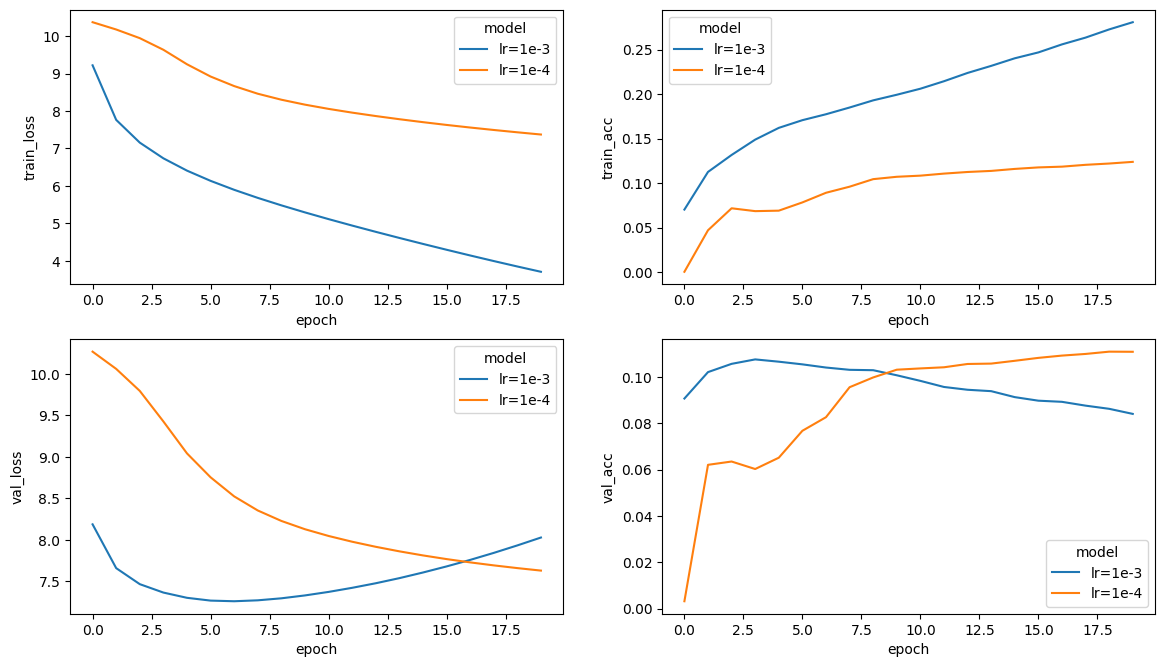

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14,8), dpi=100)
axes = axes.flatten()

plot_df = pd.concat([
    pd.DataFrame(metrics1),
    pd.DataFrame(metrics2)
], axis=0)

plot_df["model"] = ["lr=1e-3"] * (len(plot_df) // 2) + ["lr=1e-4"] * (len(plot_df) // 2)
plot_df["epoch"] = [*range(n_epochs)] * 2

sns.lineplot(x="epoch", y="train_loss", hue="model", data=plot_df, ax=axes[0])
sns.lineplot(x="epoch", y="train_acc", hue="model", data=plot_df, ax=axes[1])
sns.lineplot(x="epoch", y="val_loss", hue="model", data=plot_df, ax=axes[2])
sns.lineplot(x="epoch", y="val_acc", hue="model", data=plot_df, ax=axes[3])